### Import Packages 

In [12]:
import tensorflow as tf
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import pandas as pd
import os
import json
import yaml
import numpy as np

### Read json Files 

Here, we read the annotation file downloaded from the webite.

In [64]:
f = open('annotations/instances_train2017.json',)
train_data = json.load(f)

In [65]:
f = open('annotations/instances_val2017.json',)
val_data = json.load(f)

Let's create 2 dataframes for storing image information for train & val images. \
First, we create an empty dataframe with the columns: file_name,height,width,id. \
Next, we run the function process_json which takes the newly-created dataframe & the loaded json file as inputs. \
Image information can be found under the 'images' key of the json file. \
What the functions does is that it loops through the indices & stores the file_name,height,width & id to the dataframe. \ 

In [68]:
def process_json(df,df_data):
    '''df_data is the json file & df is the newly-created dataframe for storing the info required from the json file'''
    for i in range(len(df_data['images'])):
        df.loc[i,'file_name'] = df_data['images'][i]['file_name']
        df.loc[i,'height'] = df_data['images'][i]['height']
        df.loc[i,'width'] = df_data['images'][i]['width']
        df.loc[i,'id'] = df_data['images'][i]['id']
    print('finished image details processing')  

In [69]:
train = pd.DataFrame(columns=['file_name','height','width','id'])
process_json(train,train_data)

finished image details processing


In [71]:
val = pd.DataFrame(columns=['file_name','height','width','id'])
process_json(val,val_data)

finished image details processing


Next, we create 2 dataframes for train & val annotations. \
These dataframes will grab the annotation information using json_normalize & look at the columns image_id, category_id & bbox. \
bbox contains 4 values, the top left x coordinate, top left y coordinate, the width & heigth of the bounding box. \
We will need to separate them out, drop bbox & return the dataframe. 

In [73]:
def get_annotation(df_data):
    df_annt = pd.json_normalize(df_data['annotations'])
    df_annt = df_annt[['image_id','category_id','bbox']]
    df_annt['top_left_x'] = df_annt['bbox'].map(lambda x:x[0])
    df_annt['top_left_y'] = df_annt['bbox'].map(lambda x:x[1])
    df_annt['box_width'] = df_annt['bbox'].map(lambda x:x[2])
    df_annt['box_height'] = df_annt['bbox'].map(lambda x:x[3])
    df_annt.drop('bbox',axis=1,inplace=True)
    return df_annt

In [77]:
train_annt = get_annotation(train_data)
val_annt = get_annotation(val_data)

### Data Pre-processing 

You will notice that all train images have their annotations but not all val images do. \
Here, we drop val images if they do not have annotation data. \

In [79]:
len(set(train_annt['image_id'].unique()).intersection(train['id'].unique()))

117266

In [20]:
lis = [x for x in val['id'].unique() if x not in set(val_annt['image_id'].unique()).intersection(val['id'].unique())]
#Change path to directory where val images are stored. it should foundi n the val folder under images
for i in val.loc[val['id'].isin(lis)]['file_name']:
    os.remove(os.path.join('images/val',i))

How the dataframes should look like. \
Here, I printed out the dataframes that stored the image information & annotation information for training images.

In [80]:
train

,file_name,height,width,id
0,000000391895.jpg,360,640,391895
1,000000522418.jpg,480,640,522418
2,000000184613.jpg,336,500,184613
3,000000318219.jpg,640,556,318219
4,000000554625.jpg,640,426,554625
...,...,...,...,...
118282,000000444010.jpg,480,640,444010
118283,000000565004.jpg,427,640,565004
118284,000000516168.jpg,480,640,516168
118285,000000547503.jpg,375,500,547503


In [81]:
train_annt

,image_id,category_id,top_left_x,top_left_y,box_width,box_height
0,558840,58,199.84,200.46,77.71,70.88
1,200365,58,234.22,317.11,149.39,38.55
2,200365,58,239.48,347.87,160.00,57.81
3,200365,58,296.65,388.33,1.03,0.00
4,200365,58,251.87,333.42,125.94,22.71
...,...,...,...,...,...,...
859996,390883,1,40.00,104.00,394.00,43.00
859997,49902,53,137.00,195.00,140.00,138.00
859998,363764,43,476.00,200.00,153.00,85.00
859999,554743,1,275.00,207.00,153.00,148.00


### Create Labels 

YOLOv5 requires label files for each image to be in txt format of the following structure: \
category_id center_x center_y box_width box_height \
The coordinates & dimension info have to be scaled using image width/height. \
We shall use the convert_to_yolo function to produce our desired txt files for each image. 

We loop through the indices for train/val & do the following: \
[For each bounding box]: 
1) Get the image width & height \
2) Filter annotation dataframe for desired rows only \
3) Calculate the bounding box centre coordinates & scale them by diving by image width/height \
4) Get the bounding box width & height, scale them by dicing by image width/height 

Finally, loop through each row of box information & add it as a row to the txt file before saving it. 

In [24]:
def convert_to_yolo(i):
    '''Need to change to train/val. For e,g, w,h = train['width'][i], train['height'][i]'''
    '''Also need to change to train_annt/val_annt'''
    '''Finally, need to also change to annotations/val or annotations/train'''
    w,h = val['width'][i], val['height'][i]
    df = val_annt.loc[val_annt['image_id'] == val['id'][i]]
    df.loc[:,'b_center_x'] = df['top_left_x'] + df['box_width']/2
    df.loc[:,'b_center_y'] = df['top_left_y'] + df['box_height']/2
    df.loc[:,'b_center_x'] /= w
    df.loc[:,'b_center_y'] /= h
    df.loc[:,'box_width'] /= w
    df.loc[:,'box_height'] /= h
    df.reset_index(drop=True,inplace=True)
    print_buffer = []
    for j in range(len(df)):
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(df['category_id'][j], df['b_center_x'][j], df['b_center_y'][j], df['box_width'][j], df['box_height'][j]))
    save_file_name = os.path.join("annotations/val", val["file_name"][i].replace("jpg", "txt"))   
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

#Here, I have changed it to run on val. Please start with train before applying to val    
for idx in range(len(val)):
     convert_to_yolo(idx)    

C:\Users\resce\.conda\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
C:\Users\resce\.conda\envs\tf-gpu\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


### Prepare yaml file 

We need to create a yaml file that contains the following:
1) train image path \
2) val image path \
3) test image path \
4) number of classes \
5) list of class names

You can use the following to create the file before changing to desired format: 

In [82]:
categories = pd.json_normalize(train_data['categories'])
dict_file = [{'train' : '../images/train/'},
{'val' : '../images/val/'}, {'test': '../images/test/'}, {'nc': 80}, {'names':categories['name'].values.tolist()}]

with open(r'coco_data.yaml', 'w') as file:
    documents = yaml.dump(dict_file, file)

Now, there is a slight issue with the category_ids. \
YOLOv5 requires category_ids to start from 0 but if you examine closely, you will notice that category_id for our data starts from 1 & ends at 90, with some missing in between. \
We can fix that by first getting a list of missing category_ids. \
Then, looping through the list & add each missing category_id to the categories dataframe with None values for the other 3 columns. 

In [83]:
lis = [x for x in np.arange(0,91) if x not in categories['id'].unique()]

In [84]:
for i in lis:
    categories.loc[-1] = ['None',i,'None']
    categories.reset_index(drop=True,inplace=True)

91 classes in total. \
You will need to add this to the yaml file. 

In [85]:
categories

,supercategory,id,name
0,person,1,person
1,vehicle,2,bicycle
2,vehicle,3,car
3,vehicle,4,motorcycle
4,vehicle,5,airplane
...,...,...,...
86,None,66,None
87,None,68,None
88,None,69,None
89,None,71,None


Category name list. \
You will need to add this list to the yaml file. 

In [86]:
categories.sort_values('id')['name'].tolist()

['None',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'None',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'None',
 'backpack',
 'umbrella',
 'None',
 'None',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'None',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'None',
 'dining table',
 'None',
 'None',
 'toilet',
 'None',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'None',
 'book',
 'clock',
 'vase',
 'scissors',
 'ted

#### That's it for the data preparation part! 
#### Now, before you run the model training, kindly ensure that cuda for pytorch is available.  

In [1]:
import torch
#Should return True
torch.cuda.is_available()

True

In [2]:
torch.version.cuda

'11.3'

In [10]:
torch.__version__

'1.10.0+cu113'

### Model Training

Use the following in the command line to run model training on our custom dataset. \
We input the training script, image size to be scaled to, model architecture, model hyperparams, batch size, epochs, yaml file, pre-trained weights, no. of workers & detection file 

Please change the paths accordingly.

In [ ]:
python yolov5/train.py --img 640 --cfg yolov5/models/yolov5s.yaml --hyp yolov5/data/hyps/hyp.scratch.yaml --batch 64 --epochs 1 --data coco_dataset/coco_data.yaml --weights yolov5/weights/yolov5s.pt --workers 0 --name yolov5/coco_data_det


Use the following in the command line to run model prediction on test images. \
We input the prediction script, test image directory, our trained weights, confidence threshold, detection file

Please change the paths accordingly. 

In [ ]:
python yolov5/detect.py --source coco_dataset/images/test/ --weights yolov5\runs\train\yolov5\coco_data_det6\weights\last.pt --conf 0.25 --name yolov5\runs\train\yolov5\coco_data_det6


Finally, we can print a random image from test images & see our model predictions:

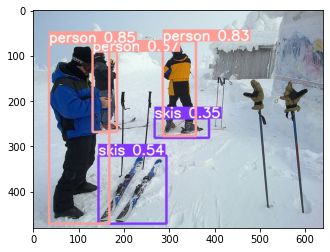

In [87]:
detections_dir = "C:\\Users\\resce\\Documents\\Jupyter Notebooks\\yolov5\\runs\\detect\\yolov5\\runs\\train\\yolov5\\coco_data_det6"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))
#plt.savefig('sample.png')